In [10]:
%qtconsole
%matplotlib inline

In [11]:
# external packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# some functions
def ts2df(ts, n_lags):
    #############################################
    ###
    #
    #
    #############################################

    # mount dataframe
    for i in range(n_lags+1):
        if i==0:
            df = ts
        else:
            df = pd.concat([df, ts.shift(i)], axis=1)

    # separate input from output
    df = df.dropna()
    df.columns = ["lag_" + str(s) for s in range(n_lags+1)]

    # output
    return df

# Feature Selection - Differential Privacy - With some signal

http://www.win-vector.com/blog/2015/10/a-simpler-explanation-of-differential-privacy/

## Parameters

In [18]:
n = 2000 # number of samples
dsignal = 10 # number of features linked with the labels
feat_noise = 0.90 # noise after signal
drandom = 100 # number of available randomly generated features
d = dsignal + drandom # number of available features
p1 = 0.5 # frequency class 1 - does not work
h = 0.5 # holdout ratio
iterations = 50 # number of iterations for forward selection
num_exp = 3 # number of experiments
T = 0.08 # Thresholdout parameter
tolerance = 0.1 # std gaussian noise
gen_error = 0.1 # generalisation error spread
B = int(gen_error*n) # budget - http://andyljones.tumblr.com/post/127547085623/holdout-reuse

## Simulation

In [19]:
from sklearn.linear_model import LogisticRegression

# pre-allocation
acc_trad = pd.DataFrame(index=[0], columns=["iter", "exp", "train", "test", "fresh"])
acc_thresh = pd.DataFrame(index=[0], columns=["iter", "exp", "train", "test", "fresh"])

# initial data
df = pd.DataFrame(np.random.normal(size=(n, d)))
df["out"] = df[list(range(dsignal))].mean(axis=1) + np.random.normal(scale=feat_noise, size=n)
df.loc[df["out"] > 0.0, "out"] = 1.0
df.loc[df["out"] < 0.0, "out"] = -1.0
df = df.sample(n=n).copy()
df.index = list(range(n))

# fresh data
df_fresh = pd.DataFrame(np.random.normal(size=(int(n*h), d)))
df_fresh["out"] = df_fresh[list(range(dsignal))].mean(axis=1) + np.random.normal(scale=feat_noise, size=int(n*h))
df_fresh.loc[df_fresh["out"] > 0.0, "out"] = 1.0
df_fresh.loc[df_fresh["out"] < 0.0, "out"] = -1.0
df_fresh = df_fresh.sample(n=int(n*h)).copy()
df_fresh.index = list(range(int(n*h)))

# classification for every feature set
g, u = 0, 0
for exp in range(num_exp):
    
    # split in training and test
    df = df.sample(n=n)
    df.index = list(range(n))
    poslabel, neglabel = np.array(df["out"] == 1.0).tolist(), np.array(df["out"] == -1.0).tolist()
    poslabel, neglabel = [i for i, x in enumerate(poslabel) if x], [i for i, x in enumerate(neglabel) if x]
    df_tr = df.loc[poslabel[:int(len(poslabel)/2.0)] + neglabel[:int(len(neglabel)/2.0)]]
    df_tr.index = list(range(len(df_tr)))
    df_ts = df.loc[poslabel[int(len(poslabel)/2.0):] + neglabel[int(len(neglabel)/2.0):]]
    df_ts.index = list(range(len(df_ts)))
       
    # traditional and blind approach
    iter_end_fmask, end_fmask, iter_fmask, fset = [], [], [], list(df.drop("out", axis=1).columns)
    for k in range(iterations): # number of iterations for feature selection

        # variable set
        test_acc = []
        for f in fset:
            # train model
            iter_fmask = end_fmask + [f]
            ml = LogisticRegression(C=10000.0).fit(df_tr[iter_fmask], df_tr["out"])

            # prediction and accuracy
            test_acc.append((ml.predict(df_ts[iter_fmask])==df_ts["out"]).mean())
            
        # pick best feature test set
        end_fmask = end_fmask + [fset[np.argmax(np.array(test_acc))]]
        fset.remove(fset[np.argmax(np.array(test_acc))])
        
        # final prediction and accuracy
        ml = LogisticRegression(C=10000.0).fit(df_tr[end_fmask], df_tr["out"])
        pred_tr = ml.predict(df_tr[end_fmask])
        pred_ts = ml.predict(df_ts[end_fmask])
        pred_fresh = ml.predict(df_fresh[end_fmask])

        # evalute the classifier in the different sets
        acc_trad.loc[g, "iter"] = k
        acc_trad.loc[g, "nvars"] = len(end_fmask)
        acc_trad.loc[g, "train"] = (pred_tr==df_tr["out"]).mean()
        acc_trad.loc[g, "test"] = (pred_ts==df_ts["out"]).mean()
        acc_trad.loc[g, "fresh"] = (pred_fresh==df_fresh["out"]).mean()
        acc_trad.loc[g, "exp"]  = exp
        iter_end_fmask.append(end_fmask)
        g+=1
        
    
    # thresholdout
    thresh_iter_end_fmask, end_fmask, iter_fmask, fset = [], [], [], list(df.drop("out", axis=1).columns)
    for k in range(iterations): # number of iterations for feature selection

        # variable set
        test_acc = []
        for f in fset:
            
            # train model
            iter_fmask = end_fmask + [f]
            ml = LogisticRegression(C=10000.0).fit(df_tr[iter_fmask], df_tr["out"])

            # prediction and accuracy
            tr_acc = (ml.predict(df_tr[iter_fmask])==df_tr["out"]).mean()
            ts_acc = (ml.predict(df_ts[iter_fmask])==df_ts["out"]).mean()
            
            # thresholdout criteria
            if abs(tr_acc-ts_acc) < T + np.random.normal(0, tolerance):
                ts_acc = tr_acc
            else:
                ts_acc += np.random.normal(0, tolerance)
            test_acc.append(ts_acc)
            
        # pick best feature test set
        end_fmask = end_fmask + [fset[np.argmax(np.array(test_acc))]]
        fset.remove(fset[np.argmax(np.array(test_acc))])
        
        # final prediction and accuracy
        ml = LogisticRegression(C=10000.0).fit(df_tr[end_fmask], df_tr["out"])
        pred_tr = ml.predict(df_tr[end_fmask])
        pred_ts = ml.predict(df_ts[end_fmask])
        pred_fresh = ml.predict(df_fresh[end_fmask])

        # evalute the classifier in the different sets
        acc_thresh.loc[u, "iter"] = k
        acc_thresh.loc[u, "nvars"] = len(end_fmask)
        acc_thresh.loc[u, "train"] = (pred_tr==df_tr["out"]).mean()
        acc_thresh.loc[u, "test"] = (pred_ts==df_ts["out"]).mean()
        acc_thresh.loc[u, "fresh"] = (pred_fresh==df_fresh["out"]).mean()
        acc_thresh.loc[u, "exp"]  = exp
        thresh_iter_end_fmask.append(end_fmask)
        u+=1
        
# final organisation
acc_thresh = acc_thresh.apply(pd.to_numeric, errors='ignore', axis=1)
acc_trad = acc_trad.apply(pd.to_numeric, errors='ignore', axis=1)

## Charts

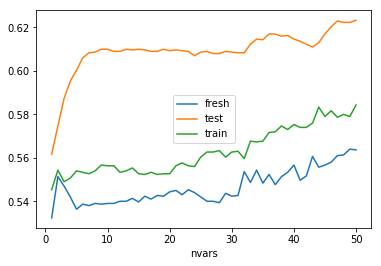

In [20]:
acc_trad.pivot_table(index="nvars").drop(["exp", "iter"], axis=1).plot()

In [21]:
iter_end_fmask

[[3],
 [3, 2],
 [3, 2, 32],
 [3, 2, 32, 92],
 [3, 2, 32, 92, 47],
 [3, 2, 32, 92, 47, 29],
 [3, 2, 32, 92, 47, 29, 26],
 [3, 2, 32, 92, 47, 29, 26, 44],
 [3, 2, 32, 92, 47, 29, 26, 44, 57],
 [3, 2, 32, 92, 47, 29, 26, 44, 57, 85],
 [3, 2, 32, 92, 47, 29, 26, 44, 57, 85, 82],
 [3, 2, 32, 92, 47, 29, 26, 44, 57, 85, 82, 50],
 [3, 2, 32, 92, 47, 29, 26, 44, 57, 85, 82, 50, 37],
 [3, 2, 32, 92, 47, 29, 26, 44, 57, 85, 82, 50, 37, 11],
 [3, 2, 32, 92, 47, 29, 26, 44, 57, 85, 82, 50, 37, 11, 71],
 [3, 2, 32, 92, 47, 29, 26, 44, 57, 85, 82, 50, 37, 11, 71, 102],
 [3, 2, 32, 92, 47, 29, 26, 44, 57, 85, 82, 50, 37, 11, 71, 102, 24],
 [3, 2, 32, 92, 47, 29, 26, 44, 57, 85, 82, 50, 37, 11, 71, 102, 24, 28],
 [3, 2, 32, 92, 47, 29, 26, 44, 57, 85, 82, 50, 37, 11, 71, 102, 24, 28, 89],
 [3,
  2,
  32,
  92,
  47,
  29,
  26,
  44,
  57,
  85,
  82,
  50,
  37,
  11,
  71,
  102,
  24,
  28,
  89,
  96],
 [3,
  2,
  32,
  92,
  47,
  29,
  26,
  44,
  57,
  85,
  82,
  50,
  37,
  11,
  71,
  102,
 

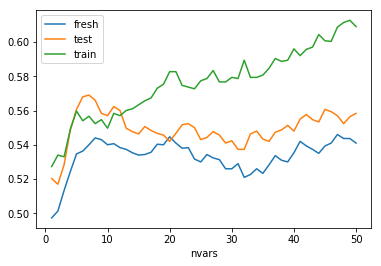

In [22]:
acc_thresh.pivot_table(index="nvars").drop(["exp", "iter"], axis=1).plot()

In [23]:
thresh_iter_end_fmask

[[10],
 [10, 63],
 [10, 63, 83],
 [10, 63, 83, 36],
 [10, 63, 83, 36, 3],
 [10, 63, 83, 36, 3, 9],
 [10, 63, 83, 36, 3, 9, 108],
 [10, 63, 83, 36, 3, 9, 108, 54],
 [10, 63, 83, 36, 3, 9, 108, 54, 55],
 [10, 63, 83, 36, 3, 9, 108, 54, 55, 71],
 [10, 63, 83, 36, 3, 9, 108, 54, 55, 71, 99],
 [10, 63, 83, 36, 3, 9, 108, 54, 55, 71, 99, 24],
 [10, 63, 83, 36, 3, 9, 108, 54, 55, 71, 99, 24, 18],
 [10, 63, 83, 36, 3, 9, 108, 54, 55, 71, 99, 24, 18, 31],
 [10, 63, 83, 36, 3, 9, 108, 54, 55, 71, 99, 24, 18, 31, 90],
 [10, 63, 83, 36, 3, 9, 108, 54, 55, 71, 99, 24, 18, 31, 90, 43],
 [10, 63, 83, 36, 3, 9, 108, 54, 55, 71, 99, 24, 18, 31, 90, 43, 34],
 [10, 63, 83, 36, 3, 9, 108, 54, 55, 71, 99, 24, 18, 31, 90, 43, 34, 52],
 [10, 63, 83, 36, 3, 9, 108, 54, 55, 71, 99, 24, 18, 31, 90, 43, 34, 52, 44],
 [10,
  63,
  83,
  36,
  3,
  9,
  108,
  54,
  55,
  71,
  99,
  24,
  18,
  31,
  90,
  43,
  34,
  52,
  44,
  88],
 [10,
  63,
  83,
  36,
  3,
  9,
  108,
  54,
  55,
  71,
  99,
  24,
  18,
  

In [24]:
list(range(dsignal))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]